In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [2]:
US_ratings = pd.read_csv('../../USData/BA_US_states_all.csv')

In [3]:
#thomas code

In [4]:
#csv file containing all the states and their neighbouring states
#empty list for states that have no neighbours (e.g Alazka, Hawaii)
neighbours_df = pd.read_csv('../../additionalData/bordering_states.csv', dtype={'state':'string', 
                                                                          'neighbours': 'string'})
neighbours_df["neighbours"] = neighbours_df["neighbours"].fillna("").apply(lambda x: x.split(";") if x else [])

neighbours_df.head(3)

,state,neighbours,nb_neighbours
0,Alabama,"[Florida, Georgia, Mississippi, Tennessee]",4
1,Alaska,[],0
2,Arizona,"[California, Colorado, Nevada, New Mexico, Utah]",5


In [5]:
def gather_region_ratings(state, US_ratings, neighbours_df):
    # Get the neighbors for the given state
    neighbours = neighbours_df.loc[neighbours_df['state'] == state, 'neighbours'].values[0]
    
    region_states = [state] + neighbours    
    region_ratings = US_ratings[US_ratings['beer_state'].isin(region_states)]

    in_region_ratings = region_ratings[region_ratings['user_state'].isin(region_states)][['rating','user_state']].tolist()
    not_in_region_ratings = region_ratings[~region_ratings['user_state'].isin(region_states)][['rating','user_state']].tolist()
    
    return in_region_ratings, not_in_region_ratings

# List of all states
states = US_ratings['beer_state'].unique()

# Initialize the combined dictionary
all_ratings = {'region': [], 'rating': [], 'rating_type': [], 'state':[]}

# Loop through each state and gather ratings
for state in states:
    # Gather ratings
    in_region, non_region = gather_region_ratings(state, US_ratings, neighbours_df)

    # Region name
    region_name = f"region_{state}"
    
    # Extend the dictionary for In-Region
    all_ratings['region'].extend([region_name] * len(in_region))
    all_ratings['rating'].extend(in_region)
    all_ratings['rating_type'].extend(['In-Region'] * len(in_region))
    all_ratings['state'].extend(state)
    
    # Extend the dictionary for Non-Region
    all_ratings['region'].extend([region_name] * len(non_region))
    all_ratings['rating'].extend(non_region)
    all_ratings['rating_type'].extend(['Non-Region'] * len(non_region))
    all_ratings['state'].extend(state)

# Convert results to a DataFrame suitable for plotting
ratings_df = pd.DataFrame(all_ratings)

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [ ]:
def gather_region_ratings(state, US_ratings, neighbours_df):
    # Get the neighbors for the given state
    neighbours = neighbours_df.loc[neighbours_df['state'] == state, 'neighbours'].values[0]
    region_states = [state] + neighbours
    
    region_ratings = US_ratings[US_ratings['beer_state'].isin(region_states)]

    # Separate in-region and out-region ratings
    in_region_ratings = region_ratings[region_ratings['user_state'].isin(region_states)][['rating', 'user_state']].values.tolist()
    not_in_region_ratings = region_ratings[~region_ratings['user_state'].isin(region_states)][['rating', 'user_state']].values.tolist()
    
    return in_region_ratings, not_in_region_ratings

# Initialize the combined dictionary
all_ratings = {'region': [], 'rating': [], 'rating_type': [], 'state': []}

# Loop through each state and gather ratings
for state in US_ratings['beer_state'].unique():
    # Gather ratings
    in_region, non_region = gather_region_ratings(state, US_ratings, neighbours_df)

    # Region name
    region_name = f"region_{state}"
    
    # Extend the dictionary for In-Region
    all_ratings['region'].extend([region_name] * len(in_region))
    all_ratings['rating'].extend([r[0] for r in in_region])  # Extract rating
    all_ratings['rating_type'].extend(['In-Region'] * len(in_region))
    all_ratings['state'].extend([r[1] for r in in_region])  # Extract user_state
    
    # Extend the dictionary for Non-Region
    all_ratings['region'].extend([region_name] * len(non_region))
    all_ratings['rating'].extend([r[0] for r in non_region])  # Extract rating
    all_ratings['rating_type'].extend(['Non-Region'] * len(non_region))
    all_ratings['state'].extend([r[1] for r in non_region])  # Extract user_state

# Convert results to a DataFrame
ratings_df = pd.DataFrame(all_ratings)

# Print the DataFrame for verification
ratings_df.head()


In [ ]:
ratings_df.head(200)

,region,rating,rating_type
0,region_Wisconsin,4.04,In-Region
1,region_Wisconsin,4.00,In-Region
2,region_Wisconsin,3.75,In-Region
3,region_Wisconsin,3.90,In-Region
4,region_Wisconsin,3.25,In-Region
...,...,...,...
195,region_Wisconsin,3.50,In-Region
196,region_Wisconsin,4.25,In-Region
197,region_Wisconsin,3.75,In-Region
198,region_Wisconsin,4.15,In-Region


In [ ]:


# Group by 'region' and 'rating_type', and calculate the average rating for each combination
ratings_df = ratings_df.groupby(['region', 'rating_type'], as_index=False)['rating'].mean()

# Rename the aggregated column for clarity
ratings_df.rename(columns={'rating': 'region_avg'}, inplace=True)

# Display the compressed DataFrame
ratings_df

,region,rating_type,region_avg
0,region_Alabama,In-Region,3.937249
1,region_Alabama,Non-Region,3.925344
2,region_Alaska,In-Region,3.970084
3,region_Alaska,Non-Region,3.954152
4,region_Arizona,In-Region,3.969709
...,...,...,...
95,region_West Virginia,Non-Region,3.883864
96,region_Wisconsin,In-Region,3.924294
97,region_Wisconsin,Non-Region,3.933459
98,region_Wyoming,In-Region,3.835038


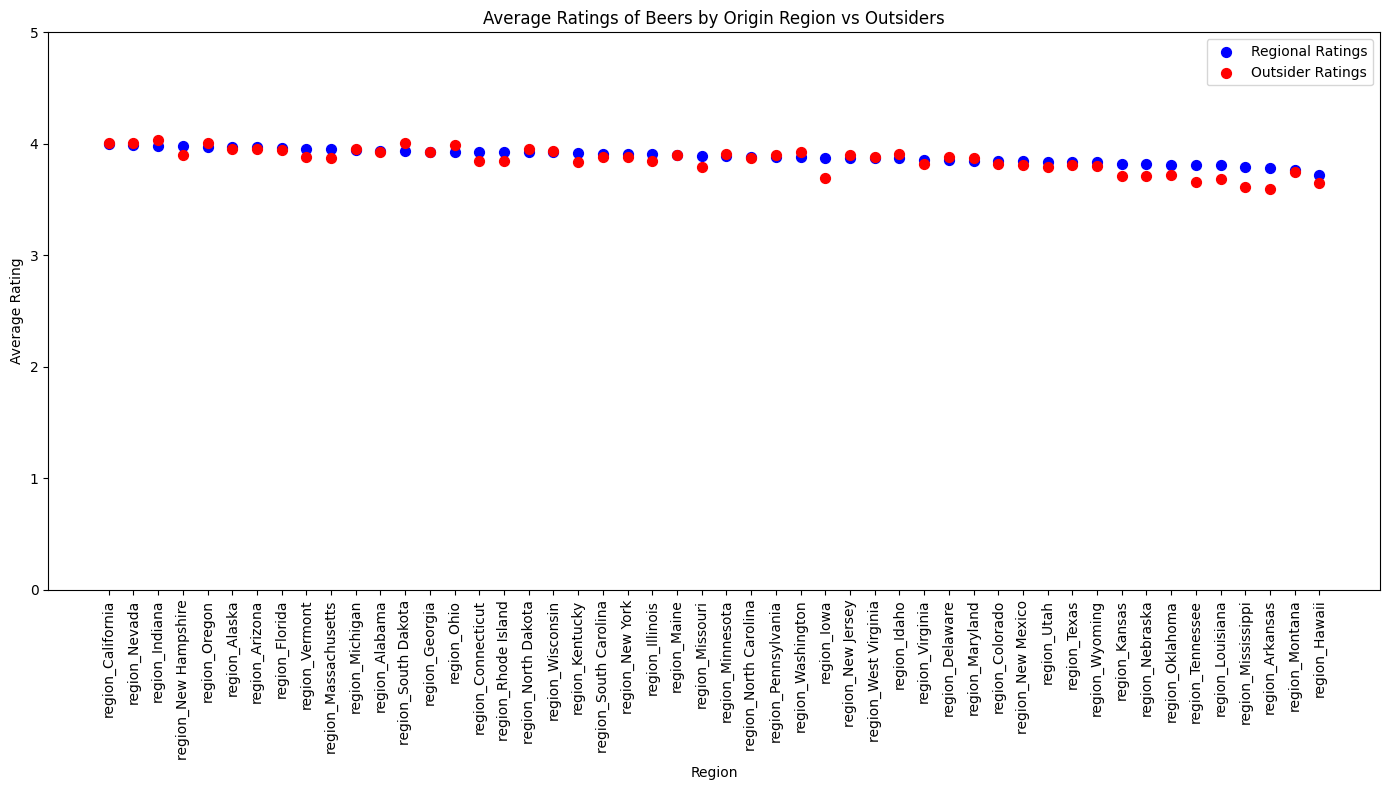

In [ ]:
# Sort the DataFrame by in_state_avg in descending order
ratings_df = ratings_df.sort_values(by='region_avg', ascending=False).reset_index(drop=True)


plt.figure(figsize=(14, 8))


plt.scatter(ratings_df[ratings_df['rating_type'] == 'In-Region']['region'], ratings_df[ratings_df['rating_type'] == 'In-Region']['region_avg'], color='blue', label='Regional Ratings', s=50)
plt.scatter(ratings_df[ratings_df['rating_type'] == 'Non-Region']['region'], ratings_df[ratings_df['rating_type'] == 'Non-Region']['region_avg'], color='red', label='Outsider Ratings', s=50)

plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylim(0,5)
plt.ylabel('Average Rating')
plt.title('Average Ratings of Beers by Origin Region vs Outsiders')
plt.legend()
plt.tight_layout()

plt.show()


In [ ]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

In [ ]:
cohen_results = {
    'region': [],
    'd_in_vs_neigh': [],
    'd_in_vs_non_neigh': []
}

# Loop over each region and calculate Cohen's d for different rating comparisons
for region in ratings_df['region'].unique():
    subset = ratings_df[ratings_df['region'] == region]
    in_region_ratings = subset[subset['rating_type'] == 'In-Region']['region_avg']
    outsider_ratings = subset[subset['rating_type'] == 'Non-Region']['region_avg']
    
    # Calculate Cohen's d values, handling cases with missing data
    d_in_vs_out = cohen_d(in_region_ratings, outsider_ratings) if len(in_region_ratings) > 0 and len(outsider_ratings) > 0 else np.nan

    # Append results for each state
    cohen_results['region'].append(region)
    cohen_results['d_in_vs_out'].append(d_in_vs_out)


# Convert results to DataFrame
cohen_df = pd.DataFrame(cohen_results)


KeyError: 'd_in_vs_out'

In [ ]:
alphabetical_cohen = cohen_df.sort_values(by='state', ascending=True, )

alphabetical_cohen.reset_index(drop=True, inplace=True)

cohen_df.head()

In [ ]:
# Plotting Cohen's D side by side for each state
plt.figure(figsize=(14, 6))
sns.barplot(x='state', y='cohen_d', hue='comparison', data=alphabetical_cohen_melted, palette='viridis')

# Add plot details
plt.title("Cohen's D: In-State vs Neighbours and In-State vs Non-Neighbours")
plt.axhline(0, color='black', linewidth=1)
plt.axhline(0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel("State")
plt.ylabel("Cohen’s D")
plt.xticks(rotation=90)
plt.legend(title="Comparison Type")
plt.tight_layout()
plt.show()